# Import all necessory libraries

In [22]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Read Data from CSV

In [6]:
corona_df = pd.read_csv('KERALA_COVID_DATASET_APR_16.csv')

# Check top 5 rows of pandaframe

In [7]:
corona_df.head()

,District,Date,Confirmed,Recovered,Active,Death
0,KASARGOD,03 February 2020,1,0,1,0
1,KASARGOD,16 February 2020,0,1,0,0
2,KASARGOD,16 March 2020,1,0,1,0
3,KASARGOD,19 March 2020,1,0,2,0
4,KASARGOD,20 March 2020,6,0,8,0


# Describing Dataframe

In [9]:
corona_df.describe()

,Confirmed,Recovered,Active,Death
count,4961.000000,4961.000000,4961.000000,4961.000000
mean,243.364644,228.233622,2860.625882,0.983068
std,255.174104,258.735088,2790.286757,1.642467
min,0.000000,0.000000,0.000000,0.000000
25%,34.000000,22.000000,358.000000,0.000000
50%,165.000000,138.000000,2121.000000,0.000000
75%,382.000000,349.000000,4571.000000,1.000000
max,1632.000000,2303.000000,12752.000000,18.000000


# Data Cleaning

### Check any null values and duplications

In [10]:
corona_df.isnull().sum()

District     0
Date         0
Confirmed    0
Recovered    0
Active       0
Death        0
dtype: int64

In [13]:
corona_df.duplicated().sum()

0

# Change Date field datatype

In [14]:
corona_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4961 entries, 0 to 4960
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   District   4961 non-null   object
 1   Date       4961 non-null   object
 2   Confirmed  4961 non-null   int64 
 3   Recovered  4961 non-null   int64 
 4   Active     4961 non-null   int64 
 5   Death      4961 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 232.7+ KB


In [15]:
corona_df["Date"] = pd.to_datetime(corona_df["Date"])

In [17]:
corona_df.head()

,District,Date,Confirmed,Recovered,Active,Death
0,KASARGOD,2020-02-03,1,0,1,0
1,KASARGOD,2020-02-16,0,1,0,0
2,KASARGOD,2020-03-16,1,0,1,0
3,KASARGOD,2020-03-19,1,0,2,0
4,KASARGOD,2020-03-20,6,0,8,0


In [19]:
corona_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4961 entries, 0 to 4960
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   District   4961 non-null   object        
 1   Date       4961 non-null   datetime64[ns]
 2   Confirmed  4961 non-null   int64         
 3   Recovered  4961 non-null   int64         
 4   Active     4961 non-null   int64         
 5   Death      4961 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 232.7+ KB


# Grouping all entries based on District

In [20]:
districtwise_df= corona_df.groupby('District').sum().reset_index()

In [21]:
districtwise_df.style.background_gradient(cmap='Blues')

,District,Confirmed,Recovered,Active,Death
0,ALAPPUZHA,86342,82745,970190,423
1,ERNAKULAM,141883,131183,1855450,474
2,IDUKKI,32204,28484,562271,51
3,KANNUR,66602,59097,864428,358
4,KASARGOD,36237,31570,561211,117
5,KOLLAM,96913,94597,992833,363
6,KOTTAYAM,91094,85685,1052137,236
7,KOZHIKODE,140489,131194,1330960,549
8,MALAPPURAM,130507,125215,1204328,460
9,PALAKKAD,65821,60937,1006079,188


# Definition to create a Horizontal Bar Chart using Plotply

In [23]:
def horizontal_bar_chart(df, x, y, title, x_label, y_label, color):
    fig = px.bar(df, x=x, y=y, orientation='h', title=title, 
                 labels={x.name: x_label,
                         y.name: y_label}, color_discrete_sequence=[color])
    fig.update_layout(yaxis={'categoryorder': 'total ascending'})
    fig.show()

# Plot graph by selecting Top 5 Districts having more Active cases

In [25]:
top_5_kerala_districts = districtwise_df.sort_values('Active', ascending=False)[:5]
horizontal_bar_chart(top_5_kerala_districts, top_5_kerala_districts.Active, top_5_kerala_districts.District,
                     'Top 5 Districts (Active Cases)', 'Number of Active cases (in Thousands)', 'States Name', 'Green')

# Grouping all entries based on Date

In [31]:
datewise_df = corona_df.groupby('Date').sum().reset_index()
datewise_df

,Date,Confirmed,Recovered,Active,Death
0,2020-01-30,1,0,1,0
1,2020-02-02,1,0,1,0
2,2020-02-03,1,0,1,0
3,2020-02-16,0,2,0,0
4,2020-02-20,0,1,0,0
...,...,...,...,...,...
400,2021-04-12,5692,2474,47596,11
401,2021-04-13,7515,2959,52132,20
402,2021-04-14,8778,2642,58245,22
403,2021-04-15,8126,2700,63651,20


# Find daily new cases and growth factor

In [35]:
datewise_df['New_case'] = datewise_df['Confirmed'] - datewise_df['Confirmed'].shift(1)
datewise_df

,Date,Confirmed,Recovered,Active,Death,New_case,Growth_factor
0,2020-01-30,1,0,1,0,NaN,NaN
1,2020-02-02,1,0,1,0,0.0,NaN
2,2020-02-03,1,0,1,0,0.0,NaN
3,2020-02-16,0,2,0,0,-1.0,-inf
4,2020-02-20,0,1,0,0,0.0,-0.000000
...,...,...,...,...,...,...,...
400,2021-04-12,5692,2474,47596,11,-1294.0,-1.633838
401,2021-04-13,7515,2959,52132,20,1823.0,-1.408810
402,2021-04-14,8778,2642,58245,22,1263.0,0.692814
403,2021-04-15,8126,2700,63651,20,-652.0,-0.516231


# Plotting line charts to compare Confirmed , New and Death Cases

In [36]:
datewise_melt_df = pd.melt(datewise_df, id_vars=['Date'], value_vars=['Confirmed', 'Death', 'New_case'])
datewise_melt_df

,Date,variable,value
0,2020-01-30,Confirmed,1.0
1,2020-02-02,Confirmed,1.0
2,2020-02-03,Confirmed,1.0
3,2020-02-16,Confirmed,0.0
4,2020-02-20,Confirmed,0.0
...,...,...,...
1210,2021-04-12,New_case,-1294.0
1211,2021-04-13,New_case,1823.0
1212,2021-04-14,New_case,1263.0
1213,2021-04-15,New_case,-652.0


In [21]:
fig = px.line(datewise_melt_df, x="Date", y="value", color='variable', 
              title="Kerala Confirmed/Death Cases Over Time")
fig.show()

In [37]:
fig = px.line(datewise_melt_df, x="Date", y="value", color='variable', 
              title="Kerala Confirmed/Death Cases Over Time (log scale)",log_y=True)
fig.show()

# Plotting line graph showing mortality rate 

In [39]:
datewise_df['Mortality'] = datewise_df['Death'] / datewise_df['Confirmed']

fig = px.line(datewise_df, x="Date", y="Mortality", 
              title="Kerala Mortality Rate Over Time")

fig.show()

# Fetching last 90 days cases to findout trends

In [42]:
datewise_df_90days=datewise_df[-90:]
datewise_df_90days

,Date,Confirmed,Recovered,Active,Death,New_case,Growth_factor,Mortality
315,2021-01-17,5005,4408,68991,21,-955.0,-2.842262,0.004196
316,2021-01-18,3346,3921,68399,17,-1659.0,1.737173,0.005081
317,2021-01-19,6186,4296,70259,26,2840.0,-1.711875,0.004203
318,2021-01-20,6815,7364,69691,18,629.0,0.221479,0.002641
319,2021-01-21,6334,6229,69771,21,-481.0,-0.764706,0.003315
...,...,...,...,...,...,...,...,...
400,2021-04-12,5692,2474,47596,11,-1294.0,-1.633838,0.001933
401,2021-04-13,7515,2959,52132,20,1823.0,-1.408810,0.002661
402,2021-04-14,8778,2642,58245,22,1263.0,0.692814,0.002506
403,2021-04-15,8126,2700,63651,20,-652.0,-0.516231,0.002461


# Analysing trends of last 90 days 

In [44]:

fig = px.line(datewise_df_90days, x="Date", y="Active", 
              title="Kerala Active Cases Over Time")

fig.show()

# Predicting number of confirmed cases in future using SVM

In [47]:
confirmed_cases = np.array(datewise_df['Confirmed']).reshape(-1, 1)

#total_deaths = np.array(datewise_df['Death']).reshape(-1, 1)

In [48]:
days = np.array([i for i in range(len(datewise_df['Date']))]).reshape(-1, 1)


In [49]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(datewise_df['Date'])+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [51]:
# slightly modify the data to fit the model better (regression models cannot pick the pattern)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_jan[:], confirmed_cases[:], test_size=0.05, shuffle=False) 

In [52]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



MAE: 4980.439218265287
MSE: 29215927.172995955


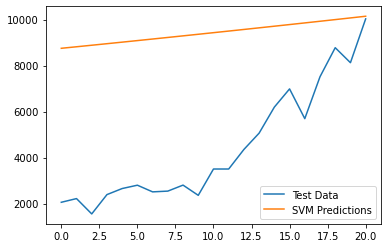

In [54]:
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [56]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 10))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('Kerala Coronavirus Cases Over Time', size=30)
    plt.xlabel('Last 30 days', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

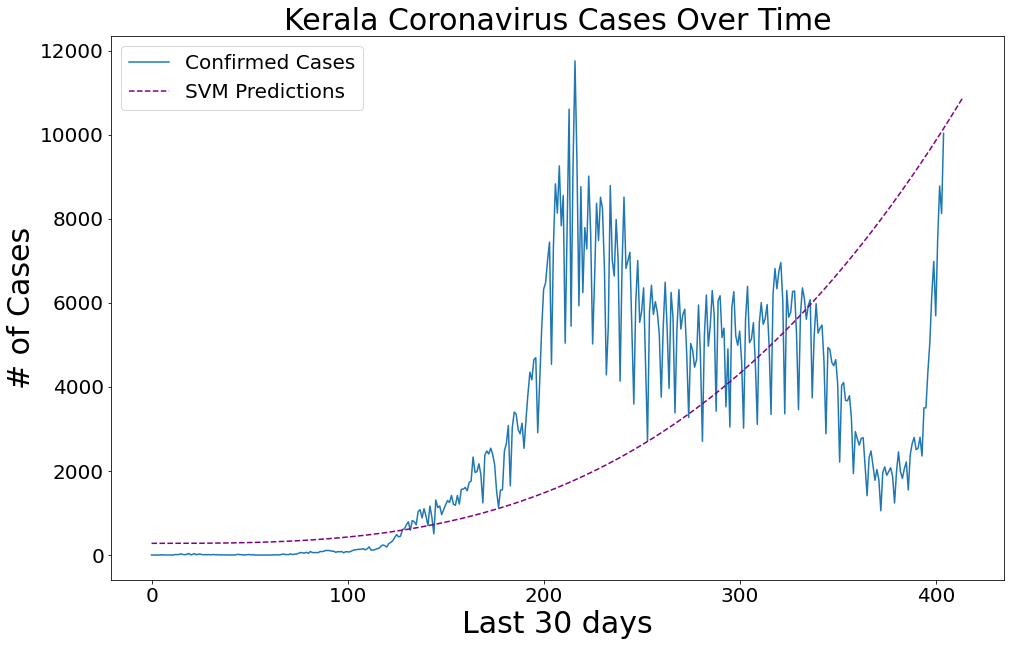

In [57]:
plot_predictions(adjusted_dates, confirmed_cases, svm_pred, 'SVM Predictions', 'purple')

# Predicting number of confirmed cases in future using Polynomial Regression

In [58]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=4)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

In [59]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 4563.410266637857
MSE: 30627935.71140761


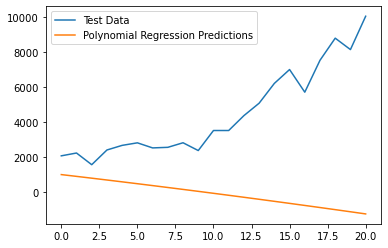

In [60]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

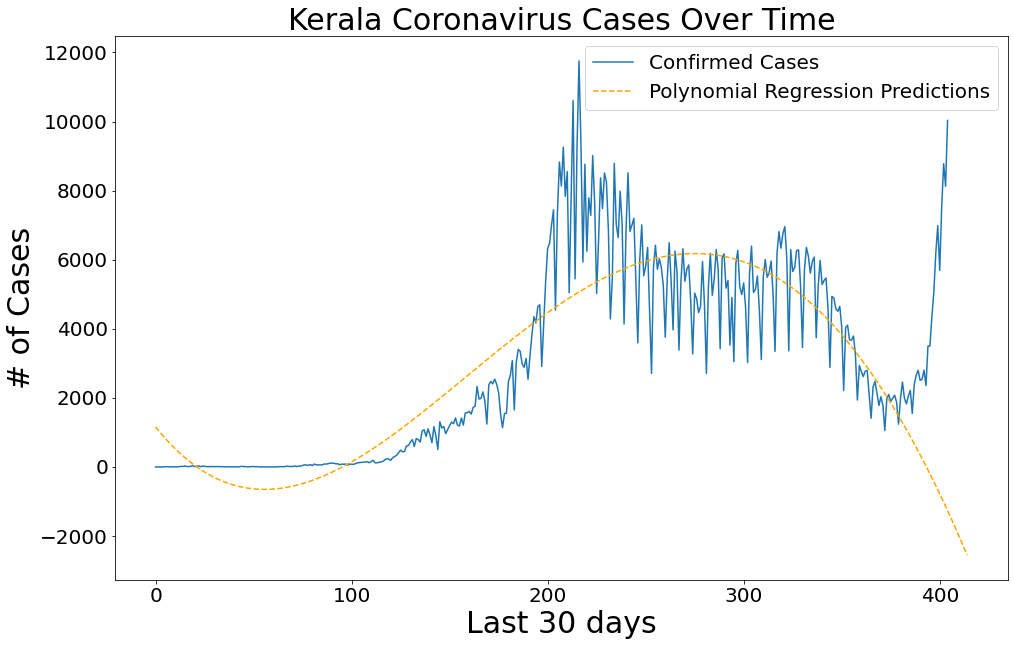

In [61]:
plot_predictions(adjusted_dates, confirmed_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')